In [23]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.stats import multivariate_normal
import pandas as pd

# 1.2

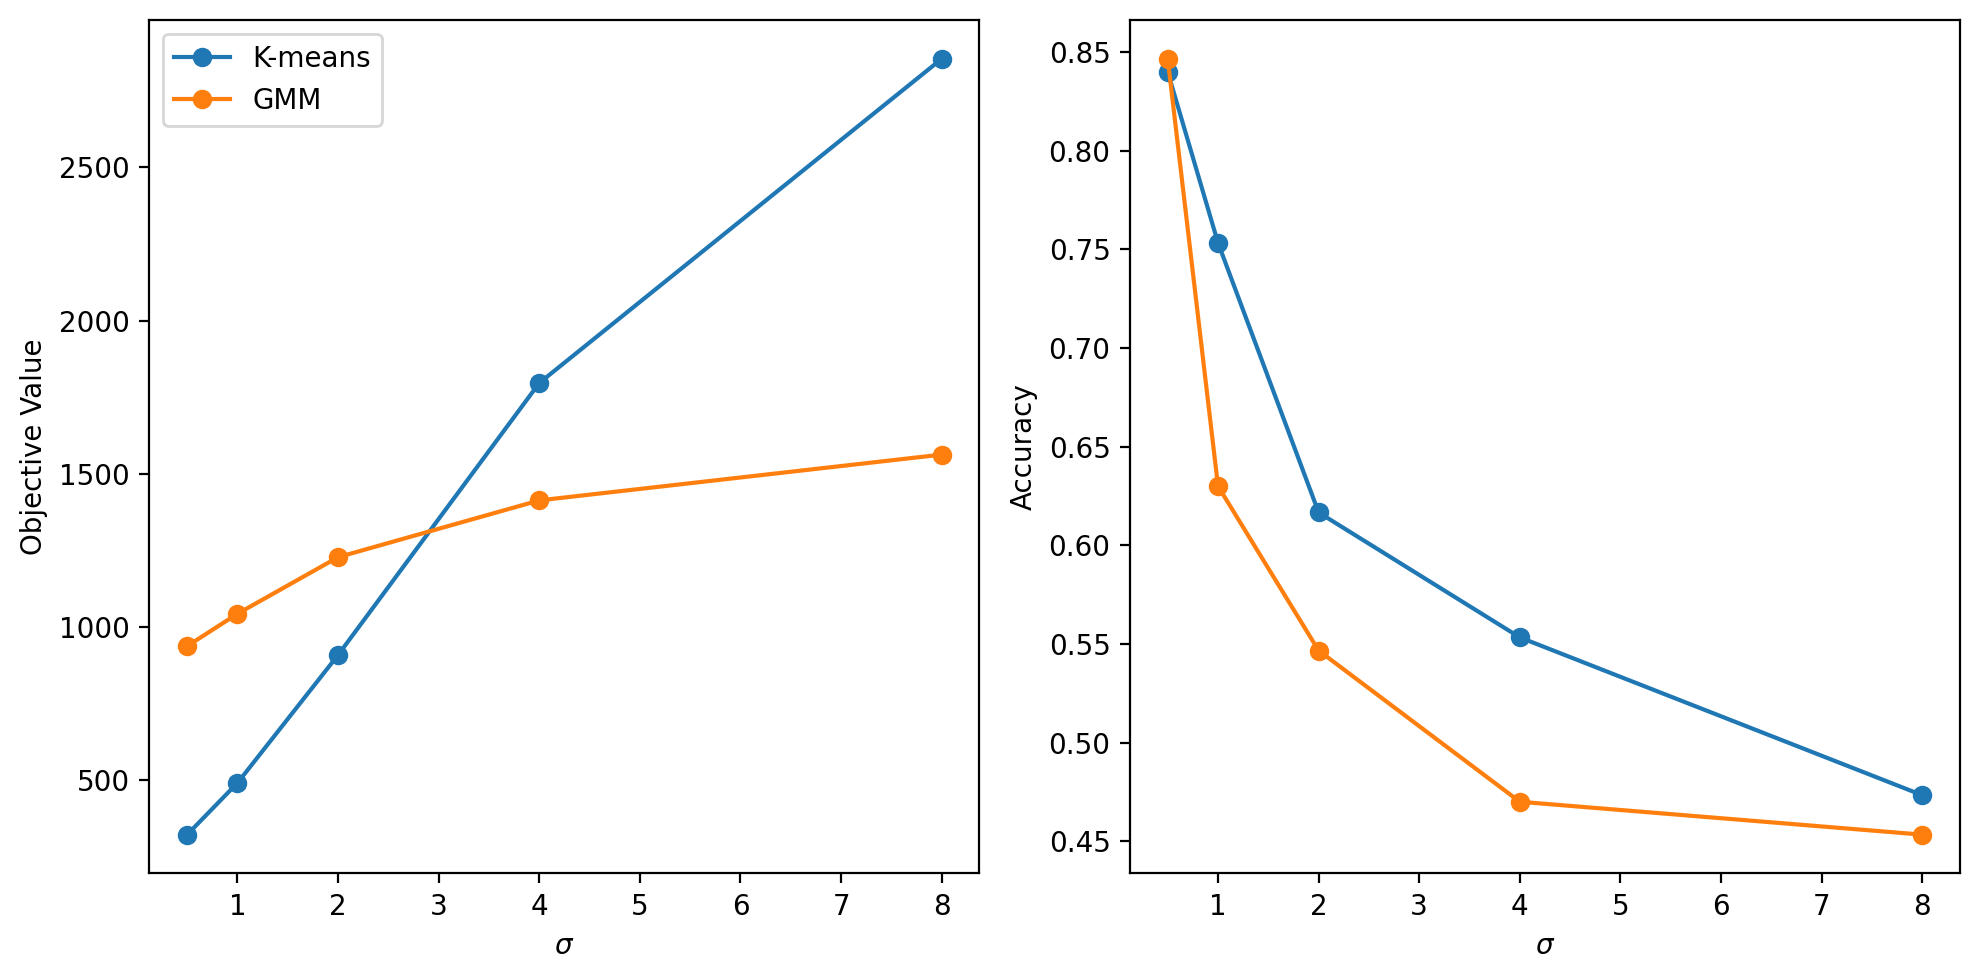

In [21]:
def generate_data(sigma):
    mean_a, cov_a = [-1, -1], sigma * np.array([[2, 0.5], [0.5, 1]])
    mean_b, cov_b = [1, -1], sigma * np.array([[1, -0.5], [-0.5, 2]])
    mean_c, cov_c = [0, 1], sigma * np.array([[1, 0], [0, 2]])
    data_a = np.random.multivariate_normal(mean_a, cov_a, 100)
    data_b = np.random.multivariate_normal(mean_b, cov_b, 100)
    data_c = np.random.multivariate_normal(mean_c, cov_c, 100)
    data = np.vstack((data_a, data_b, data_c))
    labels = np.array([0]*100 + [1]*100 + [2]*100)  # True labels
    return data, labels

# K-Means implementation
def k_means(data, k=3, max_iter=200):
    n, d = data.shape
    centroids = data[np.random.choice(n, k, replace=False)]
    for _ in range(max_iter):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        if np.all(new_centroids == centroids):
            break
        centroids = new_centroids
    return centroids, labels

# K-means objective
def kmeans_objective(data, centroids, labels):
    objective = 0
    for i in range(len(data)):
        objective += np.linalg.norm(data[i] - centroids[labels[i]])**2
    return objective

#GMM implementation
def gmm(data, k=3, max_iter=100):
    n, d = data.shape
    # Initialize parameters randomly
    phi = np.ones(k) / k
    means = data[np.random.choice(n, k, replace=False)]
    covariances = np.array([np.eye(d)] * k)

    for _ in range(max_iter):
        # E-step
        prob = np.array([multivariate_normal.pdf(data, mean=means[j], 
                                                        cov=covariances[j]) for j in range(k)]).T
        posterior = prob * phi
        posterior /= np.sum(posterior, axis=1)[:, np.newaxis]
        

        # M-step
        for j in range(k):
            weight = np.sum(posterior[:, j])
            means[j] = np.dot(posterior[:, j], data) / weight
            cov_diff = data - means[j]
            covariances[j] = np.dot(posterior[:, j] * cov_diff.T, cov_diff) / weight
            phi[j] = weight / n
    likelihood=-np.log([phi[j]*multivariate_normal.pdf(data, mean=means[j], cov=covariances[j]) 
                            for j in range(k)])
    labels = np.argmin(likelihood, axis=0)
    return means, covariances, phi,labels

# GMM negative log likelihood
def gmm_objective(data, means, covariances, phi):
    n = data.shape[0]
    k = len(phi)
    log_likelihood = 0.0
    for i in range(n):
        l_ = sum([phi[j] * multivariate_normal.pdf(data[i], mean=means[j], cov=covariances[j])
                                  for j in range(k)])
        log_likelihood += np.log(l_)
    return -log_likelihood  

#Matching the prediction label to true label
def clustering_accuracy(true_labels, predicted_labels):
    permuted_labels = itertools.permutations(set(true_labels))
   
    best_accuracy = 0
    for permutation in permuted_labels:
        permuted_labels = [permutation[label] for label in predicted_labels]
        accuracy = np.mean(np.array(permuted_labels) == true_labels)
        best_accuracy = max(best_accuracy, accuracy)
    return best_accuracy

sigmas = [0.5, 1, 2, 4, 8]
kmeans_objectives = []
kmeans_accuracies = []
gmm_objectives = []
gmm_accuracies = []

for sigma in sigmas:
    # Generate data
    data, labels = generate_data(sigma)

    # K-means
    kmeans_centers,kmeans_labels = k_means(data,k=3)
    kmeans_objectives.append(kmeans_objective(data, kmeans_centers, kmeans_labels))
    kmeans_accuracies.append(clustering_accuracy(labels, kmeans_labels))

    # GMM
    gmm_means, gmm_covs, gmm_phi,gmm_labels=gmm(data,k=3)
    gmm_objectives.append(gmm_objective(data,gmm_means, gmm_covs, gmm_phi)) 
    gmm_accuracies.append(clustering_accuracy(labels, gmm_labels))

plt.figure(figsize=(10, 5),dpi=200)
plt.subplot(121)
plt.plot(sigmas, kmeans_objectives, label='K-means', marker='o')
plt.plot(sigmas, gmm_objectives, label='GMM', marker='o')
plt.xlabel(r'$\sigma$')
plt.ylabel('Objective Value')
plt.legend()

plt.subplot(122)
plt.plot(sigmas, kmeans_accuracies, label='K-means Accuracy', marker='o')
plt.plot(sigmas, gmm_accuracies, label='GMM Accuracy', marker='o')
plt.xlabel(r'$\sigma$')
plt.ylabel('Accuracy')
#plt.legend()

plt.tight_layout()



# 2.3

### 2D data

In [70]:
def buggy_pca(X, d):
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    A = Vt[:d, :].T
    Z=X@A
    reconstructions = Z @ A.T
    return Z, reconstructions

def demeaned_pca(X, d):
    mean = np.mean(X, axis=0)
    X_centered = X - mean
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    A = Vt[:d, :].T
    Z=X_centered@A
    reconstructions = Z @ A.T+mean
    return Z, reconstructions

def normalized_pca(X, d):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_normalized = (X - mean) / std
    U, S, Vt = np.linalg.svd(X_normalized, full_matrices=False)
    A = Vt[:d, :].T
    Z=X_normalized @A
    reconstructions = (Z @ A.T) * std + mean
    return Z, reconstructions

def dro(X, d):
    b = np.mean(X, axis=0)
    X_centered = X - b
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    Z = U[:, :d] @ np.diag(S[:d])
    A = Vt[:d, :].T
    reconstructions = Z @ A.T + b
    return Z, reconstructions

def compute_reconstruction_error(X, reconstructions):
    return np.sum((X - reconstructions)**2)



Buggy PCA Reconstruction Error: 43.53314928894811
Demeaned PCA Reconstruction Error: 0.4880538024628999
Normalized PCA Reconstruction Error: 2.3740221995751343
DRO Reconstruction Error: 0.48805380246290025


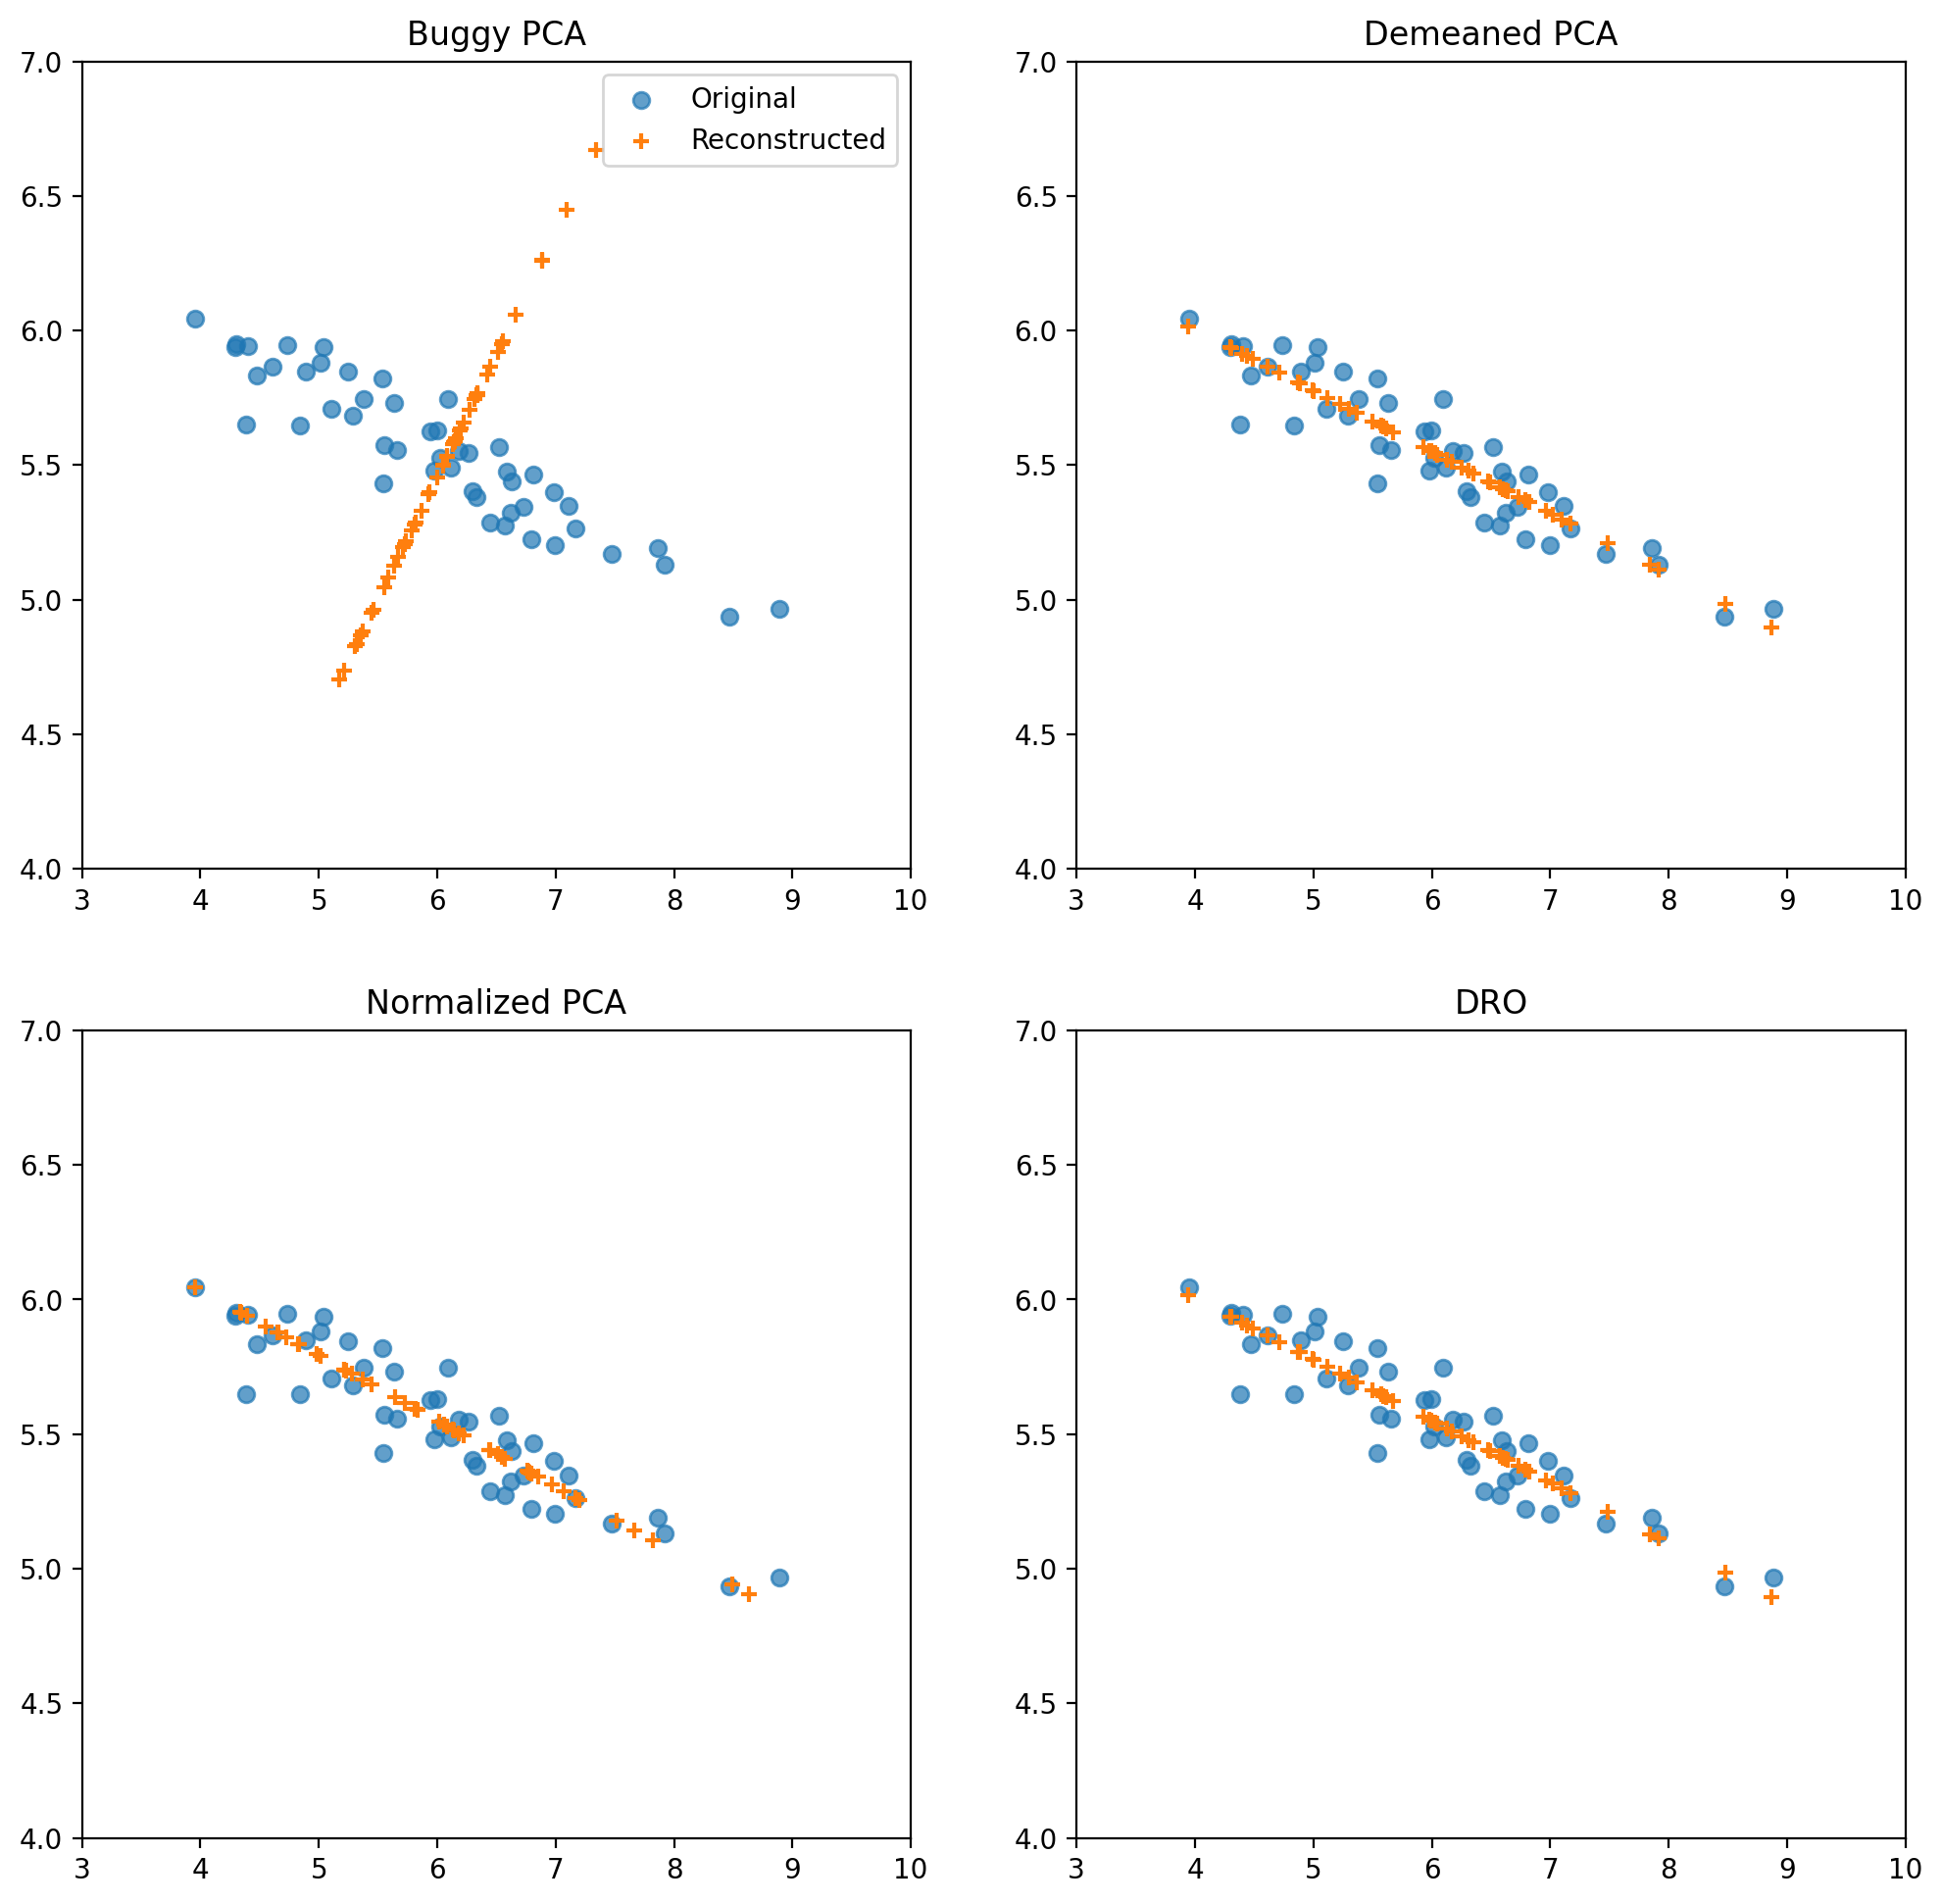

In [72]:
data1000D = pd.read_csv('data/data1000D.csv').values

d_2D = 1
Z_buggy,  recon_buggy = buggy_pca(data2D, d_2D)
Z_demeaned,  recon_demeaned = demeaned_pca(data2D, d_2D)
Z_normalized,  recon_normalized = normalized_pca(data2D, d_2D)
Z_dro, recon_dro = dro(data2D, d_2D)

plt.figure(figsize=(12, 12),dpi=200)
plt.subplot(2, 2, 1)
plt.scatter(data2D[:, 0], data2D[:, 1], label='Original',alpha=0.7)
plt.scatter(recon_buggy[:, 0], recon_buggy[:, 1], label='Reconstructed',marker='+')
plt.title('Buggy PCA')
plt.legend()
plt.xlim(3,10)
plt.ylim(4,7)

plt.subplot(2, 2, 2)
plt.scatter(data2D[:, 0], data2D[:, 1], label='Original',alpha=0.7)
plt.scatter(recon_demeaned[:, 0], recon_demeaned[:, 1], label='Reconstructed',marker='+')
plt.title('Demeaned PCA')
plt.xlim(3,10)
plt.ylim(4,7)

plt.subplot(2, 2, 3)
plt.scatter(data2D[:, 0], data2D[:, 1], label='Original',alpha=0.7)
plt.scatter(recon_normalized[:, 0], recon_normalized[:, 1], label='Reconstructed',marker='+')
plt.title('Normalized PCA')
plt.xlim(3,10)
plt.ylim(4,7)

plt.subplot(2, 2, 4)
plt.scatter(data2D[:, 0], data2D[:, 1], label='Original',alpha=0.7)
plt.scatter(recon_dro[:, 0], recon_dro[:, 1], label='Reconstructed',marker='+')
plt.title('DRO')
plt.xlim(3,10)
plt.ylim(4,7)

error_buggy_2D = reconstruction_error(data2D, recon_buggy)
error_demeaned_2D = reconstruction_error(data2D, recon_demeaned)
error_normalized_2D = reconstruction_error(data2D, recon_normalized)
error_dro = reconstruction_error(data2D, recon_dro)

print(f"Buggy PCA Reconstruction Error: {error_buggy_2D}")
print(f"Demeaned PCA Reconstruction Error: {error_demeaned_2D}")
print(f"Normalized PCA Reconstruction Error: {error_normalized_2D}")
print(f"DRO Reconstruction Error: {error_dro}")

## 1000D data

d=30


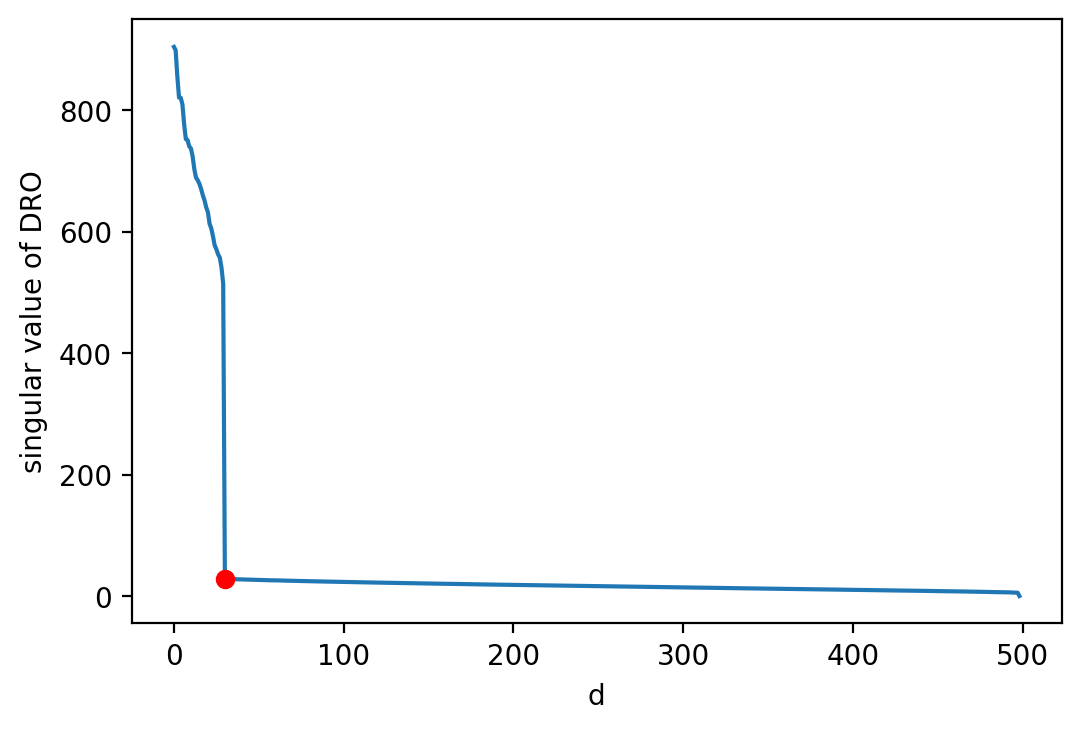

In [124]:
data1000D = pd.read_csv('data/data1000D.csv').values

X=data1000D
b = np.mean(X, axis=0)
X_centered = X - b
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
second_derivative = np.diff(S, n=2)
knee_point = np.argmax(second_derivative) + 1
plt.figure(dpi=200)
plt.plot(S)
plt.scatter([knee_point], [S[knee_point]], color='red', zorder=5)
plt.ylabel('singular value of DRO')
plt.xlabel('d')
print(f"d={knee_point}")

In [134]:
d = 30
Z_buggy, recon_buggy = buggy_pca(data1000D, d)
Z_demeaned, recon_demeaned = demeaned_pca(data1000D, d)
Z_normalized, recon_normalized = normalized_pca(data1000D, d)
Z_dro, recon_dro = dro(data1000D, d)

error_buggy = reconstruction_error(data1000D, recon_buggy)
error_demeaned = reconstruction_error(data1000D, recon_demeaned)
error_normalized = reconstruction_error(data1000D, recon_normalized)

print(f"Buggy PCA Reconstruction Error: {error_buggy}")
print(f"Demeaned PCA Reconstruction Error: {error_demeaned}")
print(f"Normalized PCA Reconstruction Error: {error_normalized}")
print(f"DRO Reconstruction Error: {error_dro}")

Buggy PCA Reconstruction Error: 401044.118956187
Demeaned PCA Reconstruction Error: 136251.13991578118
Normalized PCA Reconstruction Error: 136541.5983612821
DRO Reconstruction Error: 11102471.79099243


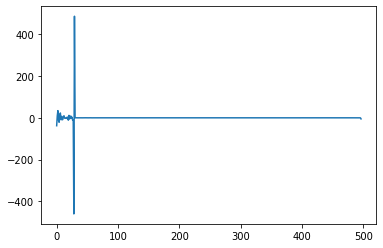

In [80]:
second_derivative = np.diff(S, n=2)
plt.plot(second_derivative)

Text(0.5, 0, 'd')

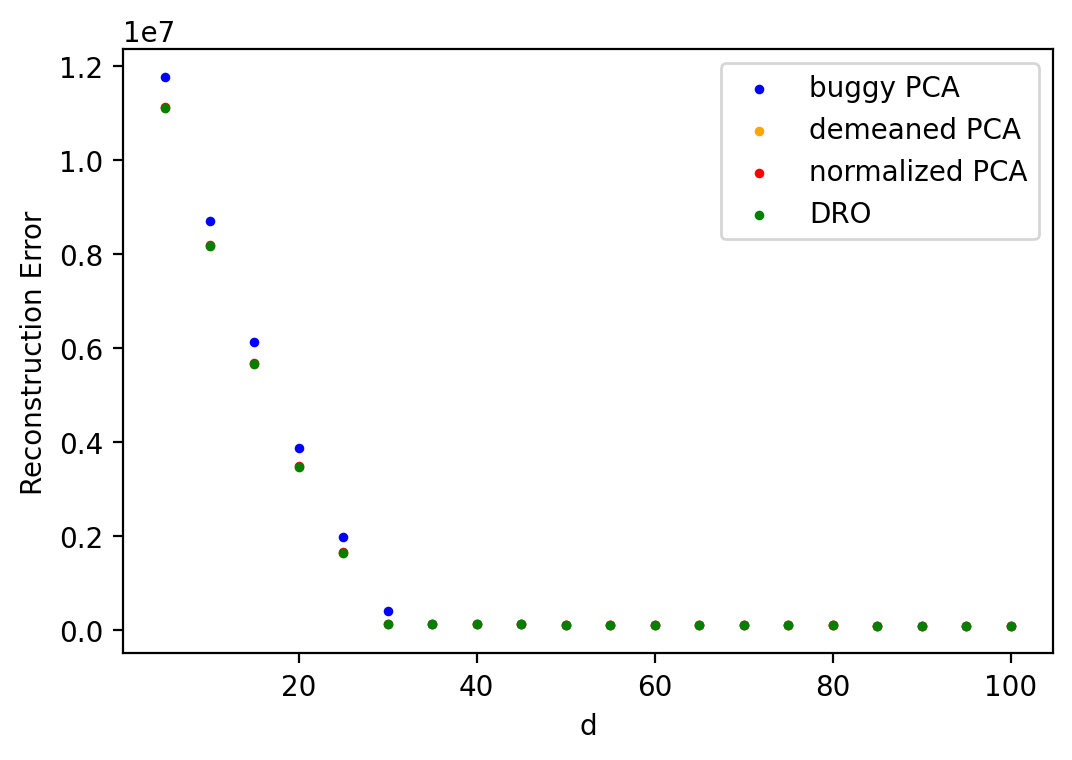

In [133]:

data1000D = pd.read_csv('data/data1000D.csv').values

plt.figure(dpi=200)
for i in range(100,0,-5):
    d = i
    Z_buggy, recon_buggy = buggy_pca(data1000D, d)
    Z_demeaned, recon_demeaned = demeaned_pca(data1000D, d)
    Z_normalized, recon_normalized = normalized_pca(data1000D, d)
    Z_dro, recon_dro = dro(data1000D, d)

    error_buggy = reconstruction_error(data1000D, recon_buggy)
    error_demeaned = reconstruction_error(data1000D, recon_demeaned)
    error_normalized = reconstruction_error(data1000D, recon_normalized)
    error_dro = reconstruction_error(data1000D, recon_dro)
    
    plt.scatter(i,error_buggy,c='blue',s=6,label='buggy PCA')
    plt.scatter(i,error_demeaned,c='orange',s=6,label='demeaned PCA')
    plt.scatter(i,error_normalized,c='red',s=6,label='normalized PCA')
    plt.scatter(i,error_dro,c='green',s=6,label='DRO')
    if i==100:
        plt.legend()
plt.ylabel('Reconstruction Error')
plt.xlabel('d')